# Assessing the use of Matten for prediction of anisotropic elastic properties

Second notebook, re-loading the results of the (somewhat long) computations in the first notebook.

In [1]:
import itertools
import json
import math

import matplotlib.pyplot as plt
from matten.predict import predict
import numpy as np
import pandas as pd
from pymatgen.core import Structure
from pymatgen.ext.matproj import MPRester
from scipy import optimize
import seaborn as sns
import torch

# This is ELATE (local copy)
import elastic

## Load data

In [2]:
with open("../datasets/crystal_elasticity_tensor.json", "r") as f:
    data = json.load(f)

test = [k for k, v in data['split'].items() if v == 'test']
structures = [Structure.from_dict(data['structure'][k]) for k in test]

real_tensor = [np.array(data['elastic_tensor_voigt'][k]) for k in test]
real_tensor = [elastic.Elastic(x) for x in real_tensor]

pred_tensor = predict(structures)
pred_tensor = [elastic.Elastic(x.zeroed().voigt) for x in pred_tensor]

/Users/fx/miniforge3/envs/matten/lib/python3.10/site-packages/torch/overrides.py:110: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  torch.has_cuda,
/Users/fx/miniforge3/envs/matten/lib/python3.10/site-packages/torch/overrides.py:111: UserWarning: 'has_cudnn' is deprecated, please use 'torch.backends.cudnn.is_available()'
  torch.has_cudnn,
/Users/fx/miniforge3/envs/matten/lib/python3.10/site-packages/torch/overrides.py:117: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  torch.has_mps,
/Users/fx/miniforge3/envs/matten/lib/python3.10/site-packages/torch/overrides.py:118: UserWarning: 'has_mkldnn' is deprecated, please use 'torch.backends.mkldnn.is_available()'
  torch.has_mkldnn,
/Users/fx/miniforge3/envs/matten/lib/python3.10/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a typ

In [3]:
with open("data_elate.json", "r") as f:
    alldata = json.load(f)

pred_minE = alldata["pred_minE"]
real_minE = alldata["real_minE"]
pred_maxE = alldata["pred_maxE"]
real_maxE = alldata["real_maxE"]

pred_minLC = alldata["pred_minLC"]
real_minLC = alldata["real_minLC"]
pred_maxLC = alldata["pred_maxLC"]
real_maxLC = alldata["real_maxLC"]

pred_minG = alldata["pred_minG"]
real_minG = alldata["real_minG"]
pred_maxG = alldata["pred_maxG"]
real_maxG = alldata["real_maxG"]

pred_minNu = alldata["pred_minNu"]
real_minNu = alldata["real_minNu"]
pred_maxNu = alldata["pred_maxNu"]
real_maxNu = alldata["real_maxNu"]

## Filter out unstable predictions

There are a numbre of crystals that have mechanically unstable tensors in the predictions. Although it creates a bias to remove them from the error estimation, they give infinite moduli for some properties, which we can't accomodate. So we filter them out.

In [4]:
# Just make sure it does not happen for the ground truth data :)
sum(np.array([np.min(np.linalg.eigvals(t.CVoigt)) for t in real_tensor]) < 0)

0

In [5]:
sum(np.array([np.min(np.linalg.eigvals(t.CVoigt)) for t in pred_tensor]) < 0)

23

In [6]:
filter = np.array([np.min(np.linalg.eigvals(t.CVoigt)) for t in pred_tensor]) > 0

In [7]:
print("Before:", len(real_tensor))
real_tensor = list(itertools.compress(real_tensor, filter))
print("After:", len(real_tensor))

Before: 1021
After: 998


In [8]:
pred_tensor = list(itertools.compress(pred_tensor, filter))

pred_minE = list(itertools.compress(pred_minE, filter))
real_minE = list(itertools.compress(real_minE, filter))
pred_maxE = list(itertools.compress(pred_maxE, filter))
real_maxE = list(itertools.compress(real_maxE, filter))

pred_minLC = list(itertools.compress(pred_minLC, filter))
real_minLC = list(itertools.compress(real_minLC, filter))
pred_maxLC = list(itertools.compress(pred_maxLC, filter))
real_maxLC = list(itertools.compress(real_maxLC, filter))

pred_minG = list(itertools.compress(pred_minG, filter))
real_minG = list(itertools.compress(real_minG, filter))
pred_maxG = list(itertools.compress(pred_maxG, filter))
real_maxG = list(itertools.compress(real_maxG, filter))

pred_minNu = list(itertools.compress(pred_minNu, filter))
real_minNu = list(itertools.compress(real_minNu, filter))
pred_maxNu = list(itertools.compress(pred_maxNu, filter))
real_maxNu = list(itertools.compress(real_maxNu, filter))

## Looking at the average properties

Check that we can reproduce the results of the Matten paper.

In [9]:
pred_averages = np.array([tensor.averages() for tensor in pred_tensor])
real_averages = np.array([tensor.averages() for tensor in real_tensor])

# We focus only on Voigt-Reuss-Hill averages
# They are given in order: bulk modulus, Young's modulus, shear modulus, Poisson's ratio
pred_avgK = pred_averages[:,2,0]
real_avgK = real_averages[:,2,0]

pred_avgE = pred_averages[:,2,1]
real_avgE = real_averages[:,2,1]

pred_avgG = pred_averages[:,2,2]
real_avgG = real_averages[:,2,2]

pred_avgNu = pred_averages[:,2,3]
real_avgNu = real_averages[:,2,3]

In [10]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

(mean_absolute_error(real_avgK, pred_avgK),
 mean_absolute_error(real_avgE, pred_avgE),
 mean_absolute_error(real_avgG, pred_avgG),
 mean_absolute_error(real_avgNu, pred_avgNu))

(7.275098210890044, 19.45233295861206, 8.388334105817641, 0.03408965632049008)

In [11]:
def mad(data):
    return np.mean(np.absolute(data - np.mean(data)))

(mean_absolute_error(real_avgK, pred_avgK) / mad(real_avgK),
 mean_absolute_error(real_avgE, pred_avgE) / mad(real_avgE),
 mean_absolute_error(real_avgG, pred_avgG) / mad(real_avgG),
 mean_absolute_error(real_avgNu, pred_avgNu) / mad(real_avgNu))

(0.1286118792672743,
 0.25934575075017235,
 0.2794115551863813,
 0.6962879124615755)

In [12]:
(math.sqrt(mean_squared_error(real_avgK, pred_avgK)),
 math.sqrt(mean_squared_error(real_avgE, pred_avgE)),
 math.sqrt(mean_squared_error(real_avgG, pred_avgG)),
 math.sqrt(mean_squared_error(real_avgNu, pred_avgNu)))

(12.865293908107011,
 31.91135601482392,
 13.685244918983766,
 0.060319686488135425)

This is in good agreement with the MAE values reported in the Matten paper for bulk, Young's and shear moduli. The analysis for the Poisson's ratio was not performed in Wen et al. We note that, even for its average property, the Poisson's ratio is not well reproduced.

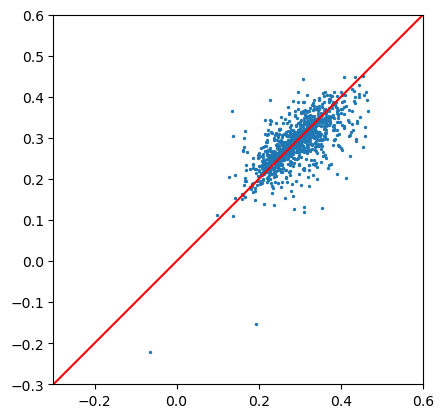

In [13]:
fig, ax = plt.subplots()
ax.scatter(real_avgNu, pred_avgNu, s=2)
ax.set_aspect(1)
ax.plot([-10, 100], [-10, 100], c='red')
ax.set_xlim(-0.3, 0.6)
_ = ax.set_ylim(-0.3, 0.6)

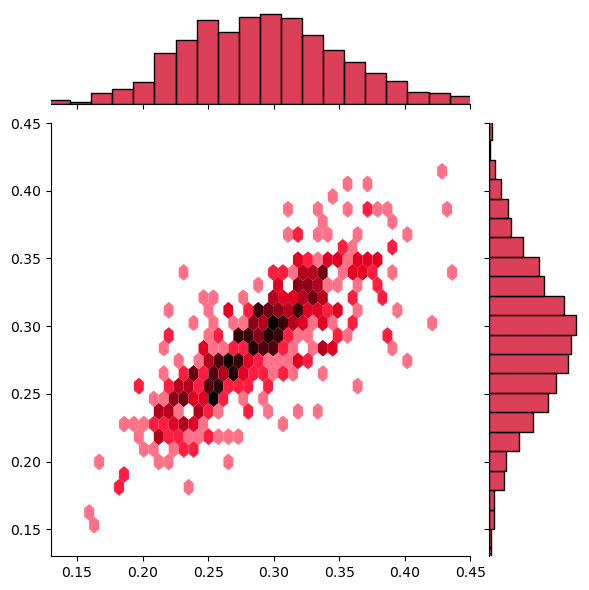

In [54]:
fig = sns.jointplot(x=real_avgNu, y=pred_avgNu, kind='hex', bins='log', ratio=4, mincnt=1, edgecolor='none',
                   xlim=(0.13, 0.45), ylim=(0.13, 0.45), gridsize=(70,  70), color='#d00020')
fig.savefig('avgNu.pdf')

## Young's modulus

Let's compare isotropic and anisotropic properties, now. We start with Young's modulus.

In [15]:
mae = mean_absolute_error(real_avgE, pred_avgE)
print("    MAE for avg_E:", mae)
print("MAE/MAD for avg_E:", mae / mad(real_avgE))

    MAE for avg_E: 19.45233295861206
MAE/MAD for avg_E: 0.25934575075017235


In [16]:
pred = np.array([x[1] for x in pred_minE])
real = np.array([x[1] for x in real_minE])
mae = mean_absolute_error(real, pred)
print("    MAE for min_E:", mae)
print("MAE/MAD for min_E:", mae / mad(real))

    MAE for min_E: 23.157060418759045
MAE/MAD for min_E: 0.35577908935141683


In [17]:
pred = np.array([x[1] for x in pred_maxE])
real = np.array([x[1] for x in real_maxE])
mae = mean_absolute_error(real, pred)
print("    MAE for max_E:", mae)
print("MAE/MAD for max_E:", mae / mad(real))

    MAE for max_E: 22.39895656760824
MAE/MAD for max_E: 0.2390904653929301


How about the direction in which the minimum or maximum is attained? How good are those predictions?

In [18]:
pred = [x[0] for x in pred_minE]
real = [x[0] for x in real_minE]

def dirVec(theta, phi):
    return [ math.sin(theta)*math.cos(phi), math.sin(theta)*math.sin(phi), math.cos(theta) ]

correl = [np.dot(dirVec(*r), dirVec(*p)) for r, p in zip(real, pred)]
angle = [np.arccos(np.dot(dirVec(*r), dirVec(*p))) for r, p in zip(real, pred)]

In [19]:
np.mean(angle) * 180 / np.pi 

38.773905041904875

In [20]:
np.median(angle) * 180 / np.pi

5.942459385011024

Wait, we're forgetting something. Because mechanical properties are centrosymmetric, if you got the right vector but in the wrong direction, it's still a good prediction :) Let's handle that case.

In [21]:
def angleBetweenVectors(u, v):
    return np.arccos(np.fabs(np.dot(u, v)))

In [22]:
angle = np.array([angleBetweenVectors(dirVec(*r), dirVec(*p)) for r, p in zip(real, pred)]) * 180 / np.pi
np.mean(angle)

29.946579335537283

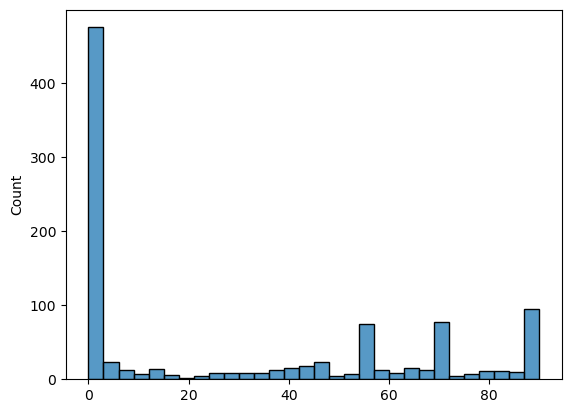

In [23]:
_ = sns.histplot(angle, bins=30, binrange=(0, 90))

In [24]:
np.sum(angle < 1) / len(angle)

0.45390781563126253

That seems like an okay prediction, actually very accurate in a way: in 45% of cases, the direction of maximal Young's modulus is predicted with accuracy better than 1°! But actually, it's not that difficult to understand. In fact, in cubic crystals, the direction of maximum Young's modulus is guaranteed to be either (1 0 0) or (1 1 1). And cubic crystals account for 42% of the database used.

In [25]:
notortho = np.array([not t.isOrthorhombic() for t in real_tensor])

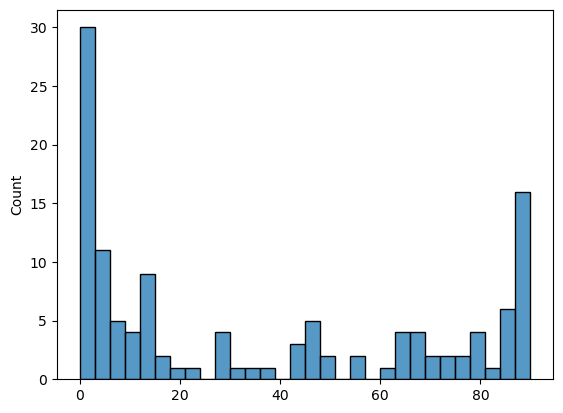

In [26]:
_ = sns.histplot(angle[notortho], bins=30, binrange=(0, 90))

In [27]:
np.mean(angle[notortho])

36.42677306577425

In [28]:
np.median(angle[notortho])

21.05772839376036

So the mean (and median) angle are not so good for non-orthorhombic structures. We can compare to a distribution of angle between purely random unit vectors:

In [43]:
def random_unit_vector():
    phi = np.random.uniform(0,np.pi*2)
    costheta = np.random.uniform(-1,1)

    theta = np.arccos(costheta)
    x = np.sin(theta) * np.cos(phi)
    y = np.sin(theta) * np.sin(phi)
    z = np.cos(theta)
    return [x,y,z]

randangle = [angleBetweenVectors(random_unit_vector(), random_unit_vector()) * 180 / np.pi for i in range(10_000)]
print(np.mean(randangle))
print(np.median(randangle))

57.48503973395807
60.017341525862754


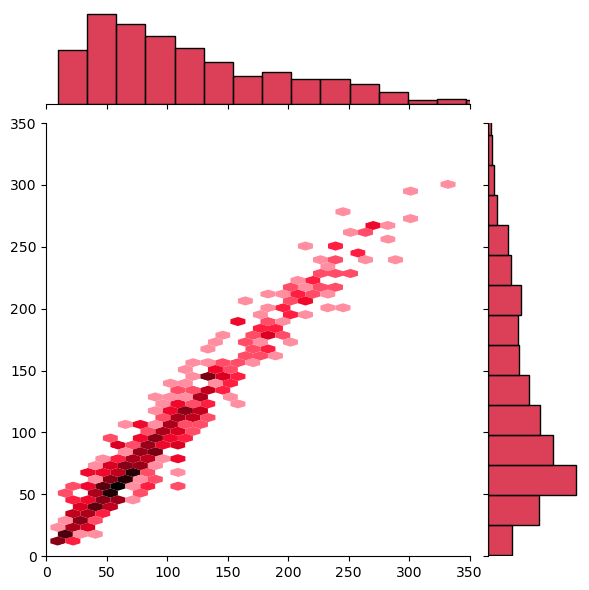

In [66]:
fig = sns.jointplot(x=real_avgE, y=pred_avgE, kind='hex', bins='log', ratio=4, mincnt=1, edgecolor='none',
                    xlim=(0, 350), ylim=(0, 350), gridsize=(70,  70), color='#d00020')

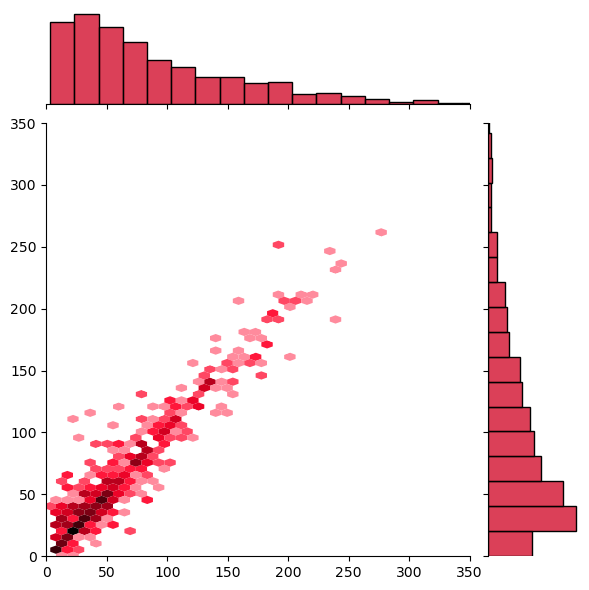

In [67]:
pred = np.array([x[1] for x in pred_minE])
real = np.array([x[1] for x in real_minE])

fig = sns.jointplot(x=real, y=pred, kind='hex', bins='log', ratio=4, mincnt=1, edgecolor='none',
                    xlim=(0, 350), ylim=(0, 350), gridsize=(70,  70), color='#d00020')

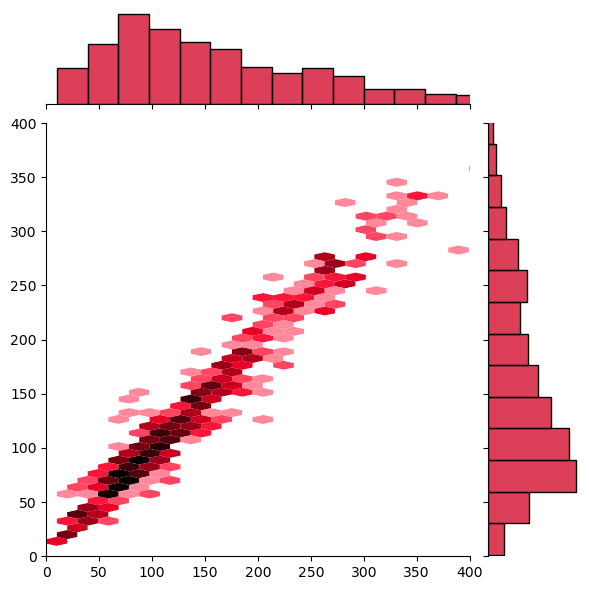

In [69]:
pred = np.array([x[1] for x in pred_maxE])
real = np.array([x[1] for x in real_maxE])

fig = sns.jointplot(x=real, y=pred, kind='hex', bins='log', ratio=4, mincnt=1, edgecolor='none',
                    xlim=(0, 400), ylim=(0, 400), gridsize=(70,  70), color='#d00020')

## Shear modulus

In [73]:
mae = mean_absolute_error(real_avgG, pred_avgG)
print("    MAE for avg_E:", mae)
print("MAE/MAD for avg_E:", mae / mad(real_avgG))

    MAE for avg_E: 8.388334105817641
MAE/MAD for avg_E: 0.2794115551863813


In [74]:
pred = np.array([x[1] for x in pred_minG])
real = np.array([x[1] for x in real_minG])
mae = mean_absolute_error(real, pred)
print("    MAE for min_G:", mae)
print("MAE/MAD for min_G:", mae / mad(real))

    MAE for min_G: 9.654383336840711
MAE/MAD for min_G: 0.3831791413278925


In [75]:
pred = np.array([x[1] for x in pred_maxG])
real = np.array([x[1] for x in real_maxG])
mae = mean_absolute_error(real, pred)
print("    MAE for max_G:", mae)
print("MAE/MAD for max_G:", mae / mad(real))

    MAE for max_G: 9.787174118384074
MAE/MAD for max_G: 0.25264233951854326


In [78]:
pred = [x[0] for x in pred_minG]
real = [x[0] for x in real_minG]

def dirVec1(theta, phi, chi):
    return [ math.sin(theta)*math.cos(phi), math.sin(theta)*math.sin(phi), math.cos(theta) ]

angle = np.array([angleBetweenVectors(dirVec1(*r), dirVec1(*p)) for r, p in zip(real, pred)]) * 180 / np.pi
np.mean(angle)

37.91887546789825

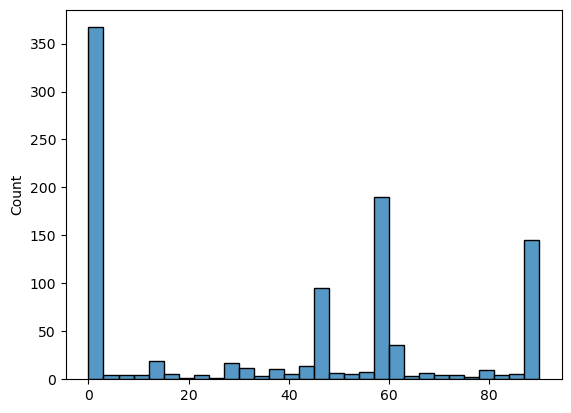

In [79]:
_ = sns.histplot(angle, bins=30, binrange=(0, 90))

In [80]:
pred = [x[0] for x in pred_maxG]
real = [x[0] for x in real_maxG]

angle = np.array([angleBetweenVectors(dirVec1(*r), dirVec1(*p)) for r, p in zip(real, pred)]) * 180 / np.pi
np.mean(angle)

28.450277061714004

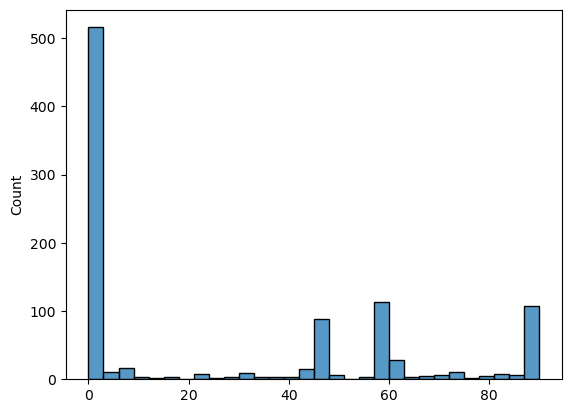

In [81]:
_ = sns.histplot(angle, bins=30, binrange=(0, 90))

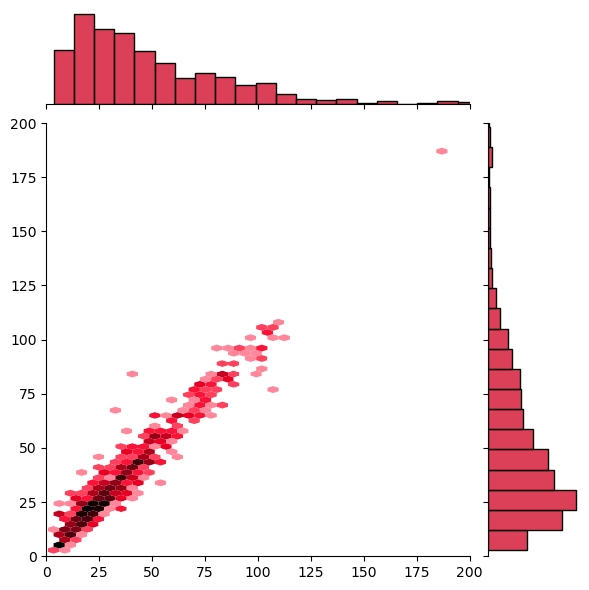

In [84]:
fig = sns.jointplot(x=real_avgG, y=pred_avgG, kind='hex', bins='log', ratio=4, mincnt=1, edgecolor='none',
                    xlim=(0, 200), ylim=(0, 200), gridsize=(70,  70), color='#d00020')

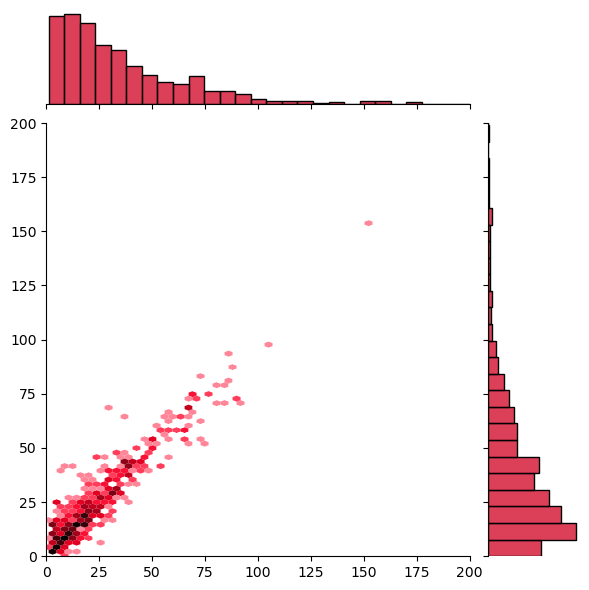

In [85]:
pred = np.array([x[1] for x in pred_minG])
real = np.array([x[1] for x in real_minG])

fig = sns.jointplot(x=real, y=pred, kind='hex', bins='log', ratio=4, mincnt=1, edgecolor='none',
                    xlim=(0, 200), ylim=(0, 200), gridsize=(70,  70), color='#d00020')

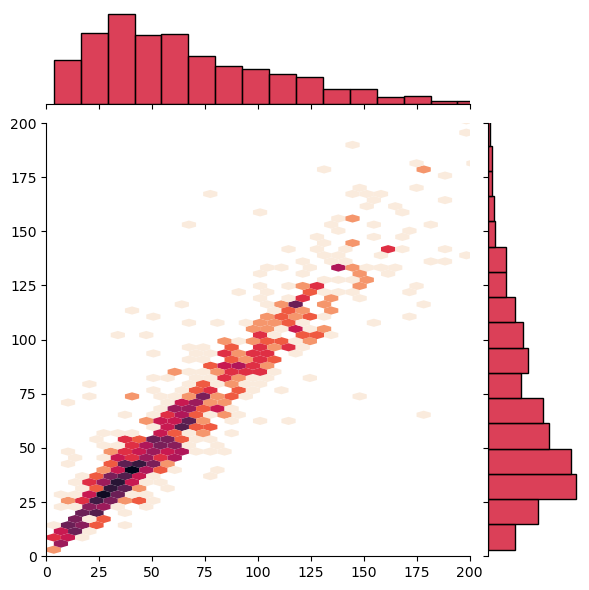

In [169]:
pred = np.array([x[1] for x in pred_maxG])
real = np.array([x[1] for x in real_maxG])

fig = sns.jointplot(x=real, y=pred, kind='hex', bins='log', ratio=4, mincnt=1, edgecolor='none',
                    xlim=(0, 200), ylim=(0, 200), gridsize=(70,  70), cmap=sns.color_palette("rocket_r", as_cmap=True), color='#d00020')

## Linear compressibility

In [131]:
pred = np.array([x[1] for x in pred_minLC])
real = np.array([x[1] for x in real_minLC])
mae = mean_absolute_error(real, pred)
print("    MAE for min_LC:", mae)
print("MAE/MAD for min_LC:", mae / mad(real))

    MAE for min_LC: 3.4885105934878045
MAE/MAD for min_LC: 1.1164829883911302


In [132]:
pred = np.array([x[1] for x in pred_maxLC])
real = np.array([x[1] for x in real_maxLC])
mae = mean_absolute_error(real, pred)
print("    MAE for max_LC:", mae)
print("MAE/MAD for max_LC:", mae / mad(real))

    MAE for max_LC: 6.253921314398223
MAE/MAD for max_LC: 0.9297982979807016


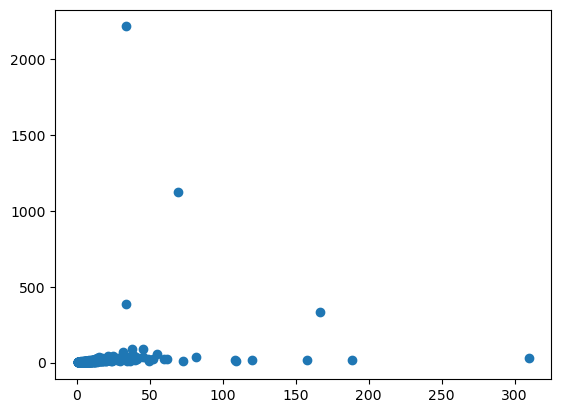

In [133]:
_ = plt.scatter(real, pred)

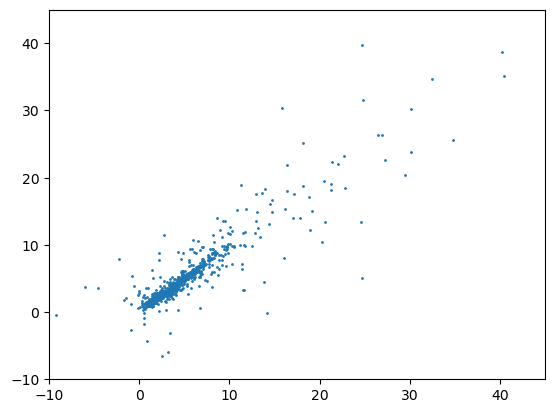

In [160]:
plt.scatter(real, pred, s=1)
plt.xlim(-10,45)
_ = plt.ylim(-10,45)

In [135]:
(pred > 100).nonzero()

(array([311, 499, 666, 708]),)

In [136]:
real_tensor[311].CVoigt

array([[17.32326028,  6.02398486,  6.02398486,  0.        ,  0.        ,
         0.        ],
       [ 6.02398486, 17.32326028,  6.02398486,  0.        ,  0.        ,
         0.        ],
       [ 6.02398486,  6.02398486, 17.32326028,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  5.01073868,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  5.01073868,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         5.01073868]])

In [137]:
pred_tensor[311].CVoigt

array([[ 4.92910194, -2.23896408, -2.23896527,  0.        ,  0.        ,
         0.        ],
       [-2.23896408,  4.92910099, -2.23896456,  0.        ,  0.        ,
         0.        ],
       [-2.23896527, -2.23896456,  4.92910194,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  4.695261  ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  4.69526052,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         4.695261  ]])

In [138]:
np.linalg.eigvals(pred_tensor[311].CVoigt)

array([0.45117235, 7.16806726, 7.16806527, 4.695261  , 4.69526052,
       4.695261  ])

In [139]:
pred_tensor[311].averages()[2]

[0.15039078394571853,
 1.222617037957777,
 4.213987245535238,
 -0.8549334671986546]

In [140]:
real_tensor[311].averages()[2]

[9.79041, 13.37723343334668, 5.257217400775538, 0.2722731830885754]

So it's a cubic material with a predicted bulk modulus of 0.15 GPa, hence its giant compressibility. The ground truth for the bulk modulus is 9.79 GPa, so we're clearly very off with this one. It becomes a huge outlier for linear compressibility.

In [141]:
pred = np.array([x[1] for x in pred_minLC])
real = np.array([x[1] for x in real_minLC])

filter = pred < 100
print("Number of outliers:", np.sum(np.logical_not(filter)))

mae = mean_absolute_error(real[filter], pred[filter])
print("    MAE for min_LC:", mae)
print("MAE/MAD for min_LC:", mae / mad(real[filter]))

Number of outliers: 1
    MAE for min_LC: 1.3030087834027755
MAE/MAD for min_LC: 0.42203374821238376


In [142]:
pred = np.array([x[1] for x in pred_maxLC])
real = np.array([x[1] for x in real_maxLC])

filter = pred < 100
print("Number of outliers:", np.sum(np.logical_not(filter)))

mae = mean_absolute_error(real[filter], pred[filter])
print("    MAE for min_LC:", mae)
print("MAE/MAD for min_LC:", mae / mad(real[filter]))

Number of outliers: 4
    MAE for min_LC: 2.500217053047521
MAE/MAD for min_LC: 0.3944273297405819


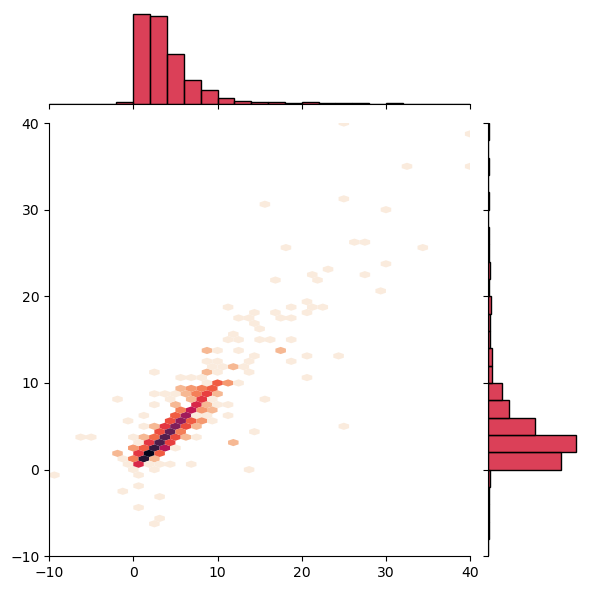

In [171]:
pred = np.array([x[1] for x in pred_minLC])
real = np.array([x[1] for x in real_minLC])

fig = sns.jointplot(x=real, y=pred, kind='hex', bins='log', ratio=4, mincnt=0, edgecolor='none',
                    xlim=(-10, 40), ylim=(-10, 40), gridsize=(40, 40),
                    cmap=sns.color_palette("rocket_r", as_cmap=True), color='#d00020',
                    marginal_kws=dict(binwidth=2, binrange=(-10,40)),
                    joint_kws=dict(extent=(-10,40,-10,40)))

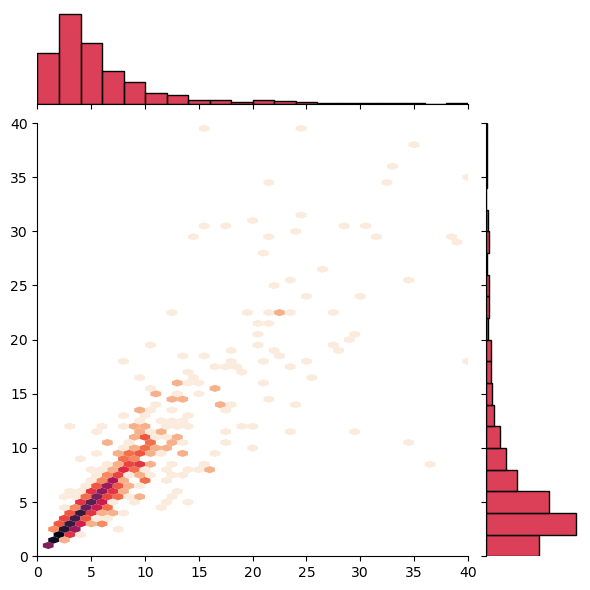

In [172]:
pred = np.array([x[1] for x in pred_maxLC])
real = np.array([x[1] for x in real_maxLC])

fig = sns.jointplot(x=real, y=pred, kind='hex', bins='log', ratio=4, mincnt=1, edgecolor='none',
                    xlim=(0, 40), ylim=(00, 40), gridsize=(40, 40),
                    cmap=sns.color_palette("rocket_r", as_cmap=True), color='#d00020',
                    marginal_kws=dict(binwidth=2, binrange=(0,40)),
                    joint_kws=dict(extent=(0,40,0,40)))

In [202]:
pred = np.array([x[1] for x in pred_minLC])
real = np.array([x[1] for x in real_minLC])

pred_NLC = pred < 0
real_NLC = real < 0

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

confusion_matrix(real_NLC, pred_NLC)

array([[972,  10],
       [ 13,   3]])

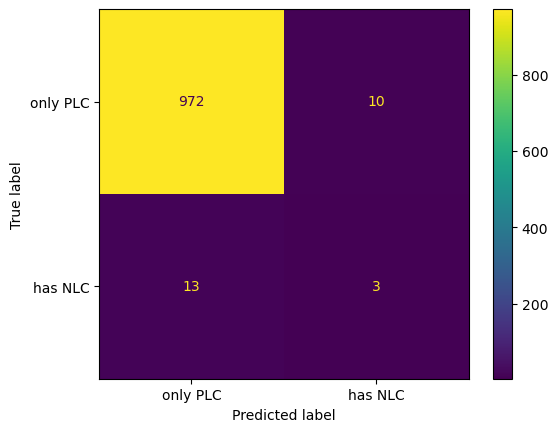

In [203]:
disp = ConfusionMatrixDisplay(confusion_matrix(real_NLC, pred_NLC),
                              display_labels=['only PLC', 'has NLC'])
_ = disp.plot()

## Poisson's ratio

In [173]:
mae = mean_absolute_error(real_avgNu, pred_avgNu)
print("    MAE for avg_Nu:", mae)
print("MAE/MAD for avg_Nu:", mae / mad(real_avgNu))

    MAE for avg_Nu: 0.03408965632049008
MAE/MAD for avg_Nu: 0.6962879124615755


In [174]:
pred = np.array([x[1] for x in pred_minNu])
real = np.array([x[1] for x in real_minNu])
mae = mean_absolute_error(real, pred)
print("    MAE for min_Nu:", mae)
print("MAE/MAD for min_Nu:", mae / mad(real))

    MAE for min_Nu: 0.11372989557272974
MAE/MAD for min_Nu: 0.8527564466232599


In [175]:
pred = np.array([x[1] for x in pred_maxNu])
real = np.array([x[1] for x in real_maxNu])
mae = mean_absolute_error(real, pred)
print("    MAE for min_Nu:", mae)
print("MAE/MAD for min_Nu:", mae / mad(real))

    MAE for min_Nu: 0.15573019931783652
MAE/MAD for min_Nu: 0.8608643273987057


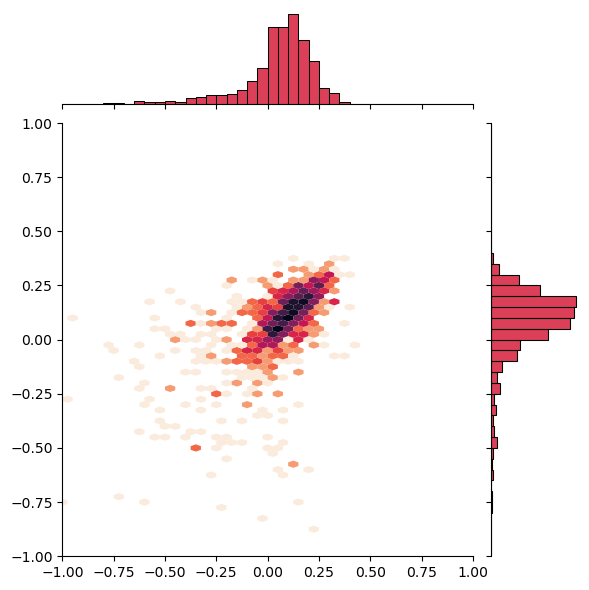

In [181]:
pred = np.array([x[1] for x in pred_minNu])
real = np.array([x[1] for x in real_minNu])

fig = sns.jointplot(x=real, y=pred, kind='hex', bins='log', ratio=4, mincnt=1, edgecolor='none',
                    xlim=(-1, 1), ylim=(-1, 1), gridsize=(40, 40),
                    cmap=sns.color_palette("rocket_r", as_cmap=True), color='#d00020',
                    marginal_kws=dict(binwidth=0.05, binrange=(-1,1)),
                    joint_kws=dict(extent=(-1,1,-1,1)))

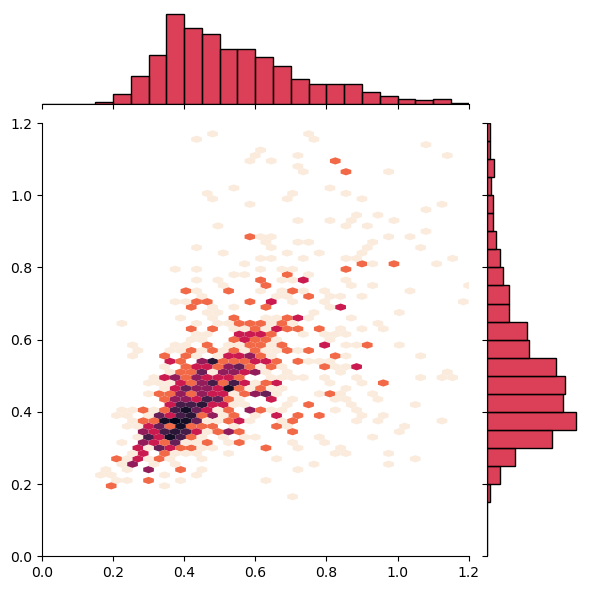

In [187]:
pred = np.array([x[1] for x in pred_maxNu])
real = np.array([x[1] for x in real_maxNu])

fig = sns.jointplot(x=real, y=pred, kind='hex', bins='log', ratio=4, mincnt=1, edgecolor='none',
                    xlim=(0, 1.2), ylim=(0, 1.2), gridsize=(40, 40),
                    cmap=sns.color_palette("rocket_r", as_cmap=True), color='#d00020',
                    marginal_kws=dict(binwidth=0.05, binrange=(0,1.2)),
                    joint_kws=dict(extent=(0,1.2,0,1.2)))

One common task is for predictors to identify metamaterials. How many materials have negative Poisson's ratio. And what is the accuracy of our predictor for that classification task?

In [194]:
pred = np.array([x[1] for x in pred_minNu])
real = np.array([x[1] for x in real_minNu])

pred_auxetic = pred < 0
real_auxetic = real < 0

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

confusion_matrix(real_auxetic, pred_auxetic)

array([[666,  72],
       [110, 150]])

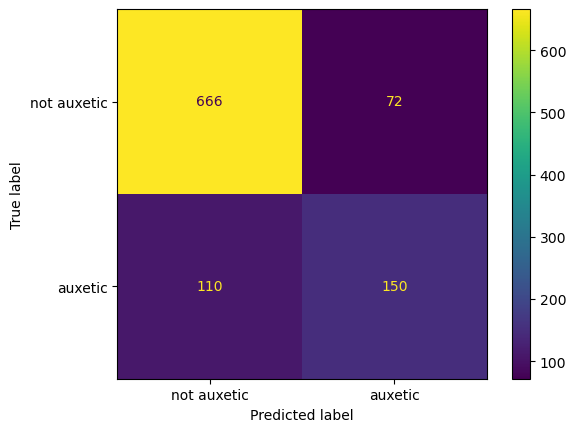

In [199]:
disp = ConfusionMatrixDisplay(confusion_matrix(real_auxetic, pred_auxetic),
                              display_labels=['not auxetic', 'auxetic'])
_ = disp.plot()